In [1]:
import numpy as np 
import os
import cv2

import keras.backend as K
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import backend as keras
from keras.metrics import accuracy
import tensorflow as tf

import matplotlib.pyplot as plt

In [2]:
%tensorflow_version 2.x

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Create 2 virtual GPUs with 1GB memory each
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=1024),
         tf.config.LogicalDeviceConfiguration(memory_limit=1024)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPU, 2 Logical GPUs


In [4]:
tf.debugging.set_log_device_placement(True)
gpus = tf.config.list_logical_devices('GPU')
strategy = tf.distribute.MirroredStrategy(gpus)
with strategy.scope():
  inputs = tf.keras.layers.Input(shape=(1,))
  predictions = tf.keras.layers.Dense(1)(inputs)
  model = tf.keras.models.Model(inputs=inputs, outputs=predictions)
  model.compile(loss='mse',
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.2))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


In [5]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8196994880626722925
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 16154099712
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11636565655840236039
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
xla_global_id: 416903419
]


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou


def fcn_2s(input_size = (256,256,3)):
    
    inputs = Input(input_size)
    x = BatchNormalization()(inputs)
    
    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)
    block_1 = Conv2D(3, (1, 1), activation='relu', padding='same')(x)
    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)
    block_2 = Conv2D(3, (1, 1), activation='relu', padding='same')(x)
    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)
    
    block_3 = Conv2D(3, (1, 1), activation='relu', padding='same')(x)
    
    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)
    
    block_4 = Conv2D(3, (1, 1), activation='relu', padding='same')(x)
    
    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)
    
    x = Conv2D(512, (3, 3), activation='relu', padding="same")(x)

    block_5 = Conv2DTranspose(3, kernel_size=(4, 4), strides=(2, 2), activation='relu', padding='same')(x)
    
    sum_1 = add([block_4, block_5])
    sum_1 = Conv2DTranspose(3, kernel_size=(4, 4), strides=(2, 2), activation='relu', padding='same')(sum_1)
    
    sum_2 = add([block_3, sum_1])
    sum_2 = Conv2DTranspose(3, kernel_size=(4, 4), strides=(2, 2), activation='relu', padding='same')(sum_2)
    
    sum_3 = add([block_2, sum_2])
    sum_3 = Conv2DTranspose(3, kernel_size=(4, 4), strides=(2, 2), activation='relu', padding='same')(sum_3) 
    
    sum_4 = add([block_1, sum_3])   
    x = Conv2DTranspose(3, kernel_size=(4, 4), strides=(2, 2), activation='sigmoid', padding='same')(sum_4)
    
    model = Model(inputs = inputs, outputs = x)

    model.compile(optimizer = Adam(learning_rate = 2e-4), loss = 'binary_crossentropy', metrics = [dice_coef, iou_coef])
    
    return model

In [51]:
def listOfFiles(directory, condition):

    x = []

    for root, dirs, files in os.walk(directory):

        for name in files:

            if condition in name:

              filename = os.path.join(root, name)

              y = filename.split('\\')

              x.append(y[0])
            
    x.sort()

    return x

In [9]:
print('*'*30)
print('Loading and preprocessing train data...')
print('*'*30)

path = '/content/drive/MyDrive/NIDA/Image_analytics/Project/datasets/DeepGlobe_Road_Extraction_Dataset/train'

condiiton_train = '_sat.jpg'
img_train_path = listOfFiles(path, condiiton_train)

condiiton_mask = '_mask.png'
img_train_mask_path = listOfFiles(path, condiiton_mask)
img_train = []
mask_train = []

for i in range(1000):
  train_im = cv2.resize(cv2.cvtColor(cv2.imread(img_train_path[i]),cv2.COLOR_BGR2RGB), (256, 256))
  mask_im = cv2.resize(cv2.cvtColor(cv2.imread(img_train_mask_path[i]),cv2.COLOR_BGR2RGB), (256, 256))
  img_train.append(train_im)
  mask_train.append(mask_im)

img_train = np.array(img_train)
img_train = img_train.astype('float32')
img_train /= 255

mask_train = np.array(mask_train)
mask_train = mask_train.astype('float32')
mask_train /= 255
mask_train[mask_train > 0.5] = 1
mask_train[mask_train <= 0.5] = 0

print('*'*30)
print('Complete preprocessing train data...')
print('*'*30)

******************************
Loading and preprocessing train data...
******************************
******************************
Complete preprocessing train data...
******************************


In [10]:
print('*'*30)
print('Creating and compiling model...')
print('*'*30)
model = fcn_2s()

******************************
Creating and compiling model...
******************************


In [11]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 3)  12         ['input_2[0][0]']                
 alization)                                                                                       
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 256, 64  1792        ['batch_normalization[0][0]']    
                                )                                                           

In [12]:
def plot_training_history(history):
    """
    Plots model training history 
    """
    fig, (ax_loss, ax_dic, ax_iou) = plt.subplots(1, 3, figsize=(15,5))
    ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
    ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax_loss.legend()
    ax_dic.plot(history.epoch, history.history["dice_coef"], label="Train dice")
    ax_dic.plot(history.epoch, history.history["val_dice_coef"], label="Validation dice")
    ax_dic.legend()
    ax_iou.plot(history.epoch, history.history["iou_coef"], label="Train iou")
    ax_iou.plot(history.epoch, history.history["val_iou_coef"], label="Validation iou")
    ax_iou.legend()

In [13]:
print('*'*30)
print('Fitting model...')
print('*'*30)

epochs = 200
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)
model_checkpoint = ModelCheckpoint(f'FCNwithDeep_{epochs}epochs.h5', monitor='loss', save_best_only=True)

history =  model.fit(img_train, mask_train, batch_size=10, epochs=epochs, verbose=1, shuffle=True,
          validation_split=0.3,
          callbacks=[model_checkpoint, early_stopping])

******************************
Fitting model...
******************************
Epoch 1/200
70/70 [==============================] - 24s 154ms/step - loss: 0.5054 - dice_coef: 0.0782 - iou_coef: 0.0389 - val_loss: 0.5092 - val_dice_coef: 0.0717 - val_iou_coef: 0.0359
Epoch 2/200
70/70 [==============================] - 10s 142ms/step - loss: 0.2960 - dice_coef: 0.0757 - iou_coef: 0.0349 - val_loss: 0.3927 - val_dice_coef: 0.0717 - val_iou_coef: 0.0350
Epoch 3/200
70/70 [==============================] - 10s 143ms/step - loss: 0.2278 - dice_coef: 0.0809 - iou_coef: 0.0338 - val_loss: 0.2959 - val_dice_coef: 0.0758 - val_iou_coef: 0.0353
Epoch 4/200
70/70 [==============================] - 10s 143ms/step - loss: 0.2045 - dice_coef: 0.0835 - iou_coef: 0.0327 - val_loss: 0.2169 - val_dice_coef: 0.0786 - val_iou_coef: 0.0337
Epoch 5/200
70/70 [==============================] - 10s 144ms/step - loss: 0.1901 - dice_coef: 0.0877 - iou_coef: 0.0331 - val_loss: 0.1952 - val_dice_coef: 0.0811 - va

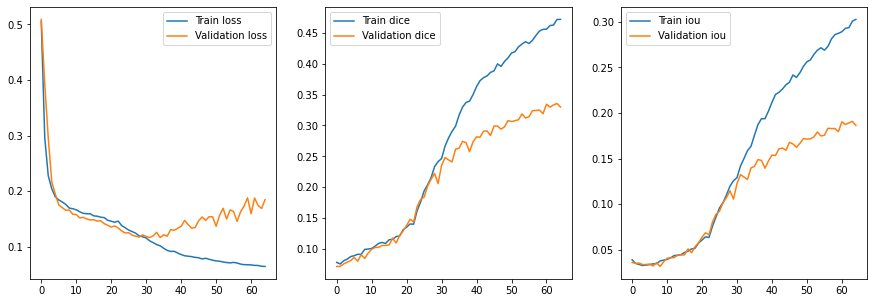

In [14]:
plot_training_history(history)

In [49]:
print('*'*30)
print('Loading saved weights...')
print('*'*30)
model.load_weights('/content/drive/MyDrive/NIDA/Image_analytics/Project/FCNwithDeep_200epochs.h5')

******************************
Loading saved weights...
******************************


In [16]:
path_test = '/content/drive/MyDrive/NIDA/Image_analytics/Project/datasets/DeepGlobe_Road_Extraction_Dataset/test'

condition_test = '_sat.jpg'
img_test_path = listOfFiles(path_test, condition_test)

condition_test_mask = '_mask.png'
img_test_mask_path = listOfFiles(path_test, condition_test_mask)


img_test = []
img_test_mask = []

for i in range(len(img_test_path)):
  test_im = cv2.resize(cv2.cvtColor(cv2.imread(img_test_path[i]),cv2.COLOR_BGR2RGB), (256, 256))
  mask_test_im = cv2.resize(cv2.cvtColor(cv2.imread(img_test_mask_path[i]),cv2.COLOR_BGR2RGB), (256, 256))
  img_test.append(test_im)
  img_test_mask.append(mask_test_im)


img_test = np.array(img_test)
img_test = img_test.astype('float32')
img_test /= 255

img_test_mask = np.array(img_test_mask)
img_test_mask = img_test_mask.astype('float32')
img_test_mask /= 255
img_test_mask[img_test_mask > 0.5] = 1
img_test_mask[img_test_mask <= 0.5] = 0


print('*'*30)
print('Evalute model on test data...')
print('*'*30)

eval = model.evaluate(img_test, img_test_mask)

******************************
Evalute model on test data...
******************************
7/7 [==============================] - 2s 134ms/step - loss: 0.1173 - dice_coef: 0.2667 - iou_coef: 0.1496


In [52]:
path_pred = '/content/drive/MyDrive/NIDA/Image_analytics/Project/datasets/DeepGlobe_Road_Extraction_Dataset/test_predict'
condition_pred = '_sat.jpg'
img_pred_path = listOfFiles(path_pred, condition_pred)
img_pred = []

for i in range(len(img_pred_path)):
  pred_im = cv2.resize(cv2.cvtColor(cv2.imread(img_pred_path[i]),cv2.COLOR_BGR2RGB), (256, 256))
  img_pred.append(pred_im)

img_pred = np.array(img_pred)
img_pred = img_pred.astype('float32')
img_pred /= 255

print('*'*30)
print('Predicting masks on test data...')
print('*'*30)
mask_pred = model.predict(img_pred, verbose=1)

******************************
Predicting masks on test data...
******************************
35/35 [==============================] - 3s 99ms/step


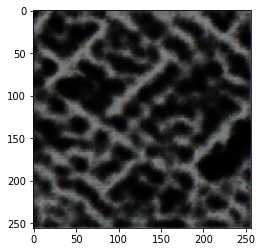

In [53]:
plt.imshow(mask_pred[10])

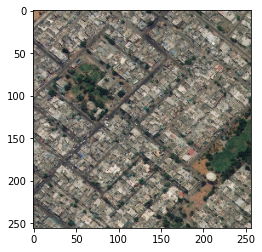

In [54]:
plt.imshow(img_pred[10])